In [50]:
import numpy as np
import time
from math import sqrt, pi, exp
import functools
import scipy
import matplotlib.pylab as pl
from varname import nameof


from utils.preconditioners import *
from utils.algorithms import *
from utils.functions import *

### Test case "Gaussian"

[[ 0.6 -0.4]
 [-0.4  0.6]]


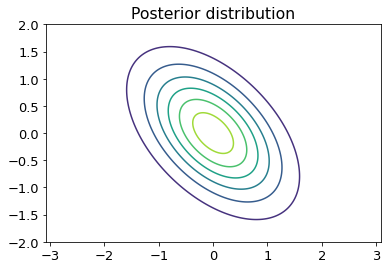

In [51]:
d = 2

y = np.zeros(1)
xmin = -2
xmax = 2
ymin= -2
ymax= 2


# potential function
sigNoise = 1
sigPrior = 1

G = lambda u:  u[0] + u[1] # model
Phi = lambda u: 0.5/(sigNoise**2)*(G(u)-y)**2 #likelihood

# potential function
I = lambda u: 0.5/(sigPrior**2)*np.linalg.norm(u,axis=0)**2 + Phi(u)

# compute Sigma posterior (the target covariance matrix)


g = np.asarray([[1], [1]])
K_inv = np.eye(d,d)*(1/sigPrior**2) + functools.reduce(np.dot, [g.T, np.eye(d,d)*(1/sigNoise**2),g])
K = np.linalg.solve(K_inv,np.eye(d,d))
print(K)

# plot posterior

u0s = np.linspace(xmin,xmax,150) # draw a grid of 150 points in 2d
u1s = np.linspace(ymin,ymax,150)
U0, U1 = np.meshgrid(u0s,u1s)
U = np.stack((U0,U1)) # size (2, 150, 150)
#print(U.shape)

plt.figure()
plt.contour(U0, U1, np.exp(-I(U)))  # plot normalized density
plt.title("Posterior distribution")
plt.axis('equal')
plt.show()


unnorm_dens = np.exp(-I(U))
Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z

marg_over_x = np.trapz(dens, u0s, axis=1)
marg_over_y = np.trapz(dens, u1s, axis=0)

In [28]:
print(K_inv)
print(np.trace(K_inv))

print(K)

[[3. 2.]
 [2. 3.]]
6.0
[[ 0.6 -0.4]
 [-0.4  0.6]]


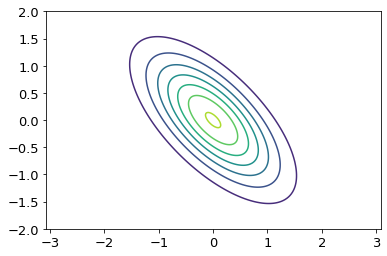

In [35]:
# compare with Gaussian with covariance K given by the formula

m = np.array([[0],[0]])  # defining the mean of the Gaussian (mX = 0.2, mY=0.6)
#cov = np.array([[0.5, -0.3], [-0.3, 0.5]])   # defining the covariance matrix
cov = K
cov_inv = np.linalg.inv(cov)  # inverse of covariance matrix
cov_det = np.linalg.det(cov)  # determinant of covariance matrix
# Plotting
x = np.linspace(-2, 2)
y = np.linspace(-2, 2)
X,Y = U0,U1
coe = 1.0 / ((2 * np.pi)**2 * cov_det)**0.5
Z = coe * np.e ** (-0.5 * (cov_inv[0,0]*(X-m[0])**2 + (cov_inv[0,1] + cov_inv[1,0])*(X-m[0])*(Y-m[1]) + cov_inv[1,1]*(Y-m[1])**2))
plt.contour(X,Y,Z)
plt.axis('equal')
plt.show()

### Try algorithms

iter
0
lambda min
0.9289279988533072
trace D opt
1.9999999999999996



/Users/annakorba/Desktop/nreks/utils/algorithms.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  


iter
100
lambda min
0.5059851601544023
trace D opt
2.0000000000000004

iter
200
lambda min
0.21416019873740755
trace D opt
2.0

iter
300
lambda min
0.3427365374713422
trace D opt
2.0

iter
400
lambda min
0.5027615590200175
trace D opt
2.000000000000001

iter
500
lambda min
0.5891991222390158
trace D opt
1.9999999999999996

iter
600
lambda min
0.25244068895778676
trace D opt
2.000000000000001

iter
700
lambda min
0.2198100883677233
trace D opt
1.9999999999999998

iter
800
lambda min
0.3657945158142146
trace D opt
2.0

iter
900
lambda min
0.1299683823149116
trace D opt
2.0

iter
1000
lambda min
0.2149821520452096
trace D opt
1.9999999999999996

iter
1100
lambda min
0.37266553198727986
trace D opt
2.0

iter
1200
lambda min
0.3006096290422842
trace D opt
1.9999999999999998

iter
1300
lambda min
0.19540666851030342
trace D opt
2.0

iter
1400
lambda min
0.22063401386663511
trace D opt
2.0000000000000004

iter
1500
lambda min
0.4020615473223419
trace D opt
2.0000000000000004

iter
1600
lambda

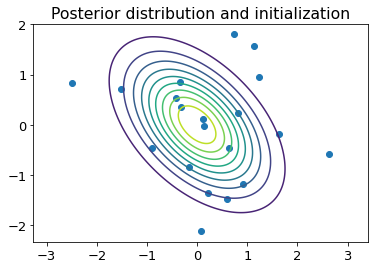

In [16]:


# run algorithms

# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 3000 # number of iterations
d = 2 # dimension
tau = 1e-3 # step size

# parameters of our algorithm
const = 1.5 


# initial position of the particles

u0 = np.random.normal(0,1.0,(d,J)) 

plt.figure()
plt.contour(U0, U1, np.exp(-I(U)), 10)
plt.scatter(u0[0],u0[1])
plt.axis('equal')
plt.title("Posterior distribution and initialization")

"""

# ULA
start_time = time.time()
us_list_ULA = run_ULA(I, N_sim, u0, tau)
np.save('save_data/gaussian/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
        +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'.npy', us_list_ULA)
print(f"ULA: {time.time()-start_time} seconds")

# ALDI 
start_time = time.time()
us_list_ALDI = run_ALDI_with_gradient(I, N_sim, u0, tau)
np.save('save_data/gaussian/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
                    +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'.npy', us_list_ALDI)
print(f"ALDI with gradient: {time.time()-start_time} seconds")

"""
# NRALDI (our scheme)
# eventually new parameters like stepsize

tau_ALDINR = 1e-3
#tau_ALDINR = tau

start_time = time.time()
us_list_ALDINR, preconditioners = run_ALDINR(I, N_sim, u0, tau_ALDINR, const) 


# save data
np.save('save_data/gaussian/ALDINR_J_'\
                      +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'.npy', us_list_ALDINR)

np.save('save_data/gaussian/ALDINR_J_'\
                      +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)\
                      +'_preconditioners'+'.npy', preconditioners)

print(f"ALDI NR: {time.time()-start_time} seconds")



In [52]:
# load data

us_list_ULA = np.load('save_data/gaussian/ULA_J_20_Nsim_3000_tau_0.001.npy')
us_list_ALDI = np.load('save_data/gaussian/ALDI_J_20_Nsim_3000_tau_0.001.npy')

us_list_ALDINR = np.load('save_data/gaussian/ALDINR_J_20_Nsim_3000_tau_0.001.npy')
preconditioners_ALDINR = np.load('save_data/gaussian/ALDINR_J_20_Nsim_3000_tau_0.001_preconditioners.npy')

tau = 0.001
tau_ALDINR = tau

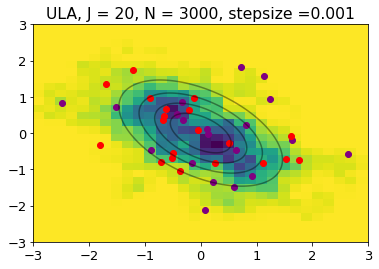

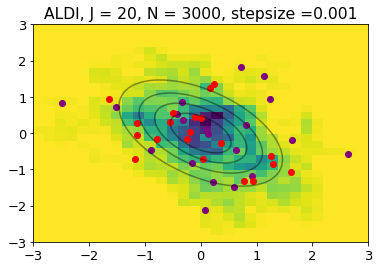

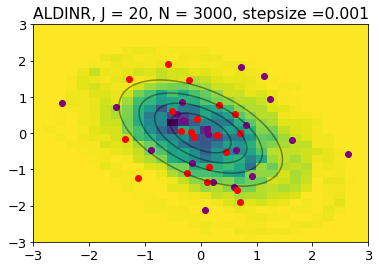

In [53]:
# plot results
    
name = nameof(us_list_ULA).lstrip('us_list')
plot_results(I, us_list_ULA, tau, name, xmin = -3, xmax = 3, ymin = -3, ymax = 3)
plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0], color = "purple")
plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red")


name = nameof(us_list_ALDI).lstrip('us_list')
plot_results(I, us_list_ALDI, tau, name, xmin = -3, xmax = 3, ymin = -3, ymax = 3)
plt.scatter(us_list_ALDI[0, :, 0], us_list_ALDI[1, :, 0], color = "purple")
plt.scatter(us_list_ALDI[0, :, -1], us_list_ALDI[1, :, -1], color = "red")


name = nameof(us_list_ALDINR).lstrip('us_list')
plot_results(I, us_list_ALDINR, tau_ALDINR, name, xmin = -3, xmax = 3, ymin = -3, ymax = 3)
plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple")
plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red")



## Plot some statistics for ALDINR

In [8]:
# plot Trace of T = (D_opt + J_opt)
#y = np.trace(preconditioners)
#y.shape
#plt.plot(y)
#plt.title('Trace of (D_opt + J_opt)')
#plt.xlabel('Iterations')
#plt.show()
# it seems that Trace(T) = d

#a = [tau_ALDINR * np.trace(np.dot(preconditioners[:, :, i], K_inv)) for i in range(preconditioners.shape[2])]
#b = tau * d 
#print("tau ALDINR")
#print(tau_ALDINR)
#print("tau ALDI")
#print(tau)
#print("tau ALDI times d ")
#print(b)

#plt.plot(a)
#plt.title('Trace((D_opt + J_opt)K^{-1})')
#plt.show()

### Plot means, covariances along the flow

In [54]:
# compute means and covariances

J = us_list_ULA.shape[1]
N_sim = us_list_ULA.shape[2]


means_ULA = np.mean(us_list_ULA, axis = 1)
means_ALDI = np.mean(us_list_ALDI, axis = 1)
means_ALDINR = np.mean(us_list_ALDINR, axis = 1)


covariances_ULA = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ULA[:,:, i] = np.cov(us_list_ULA[:, :, i])*(J-1)/J
 
covariances_ALDI = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDI[:,:, i] = np.cov(us_list_ALDI[:, :, i])*(J-1)/J

covariances_ALDINR = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDINR[:,:, i] = np.cov(us_list_ALDINR[:, :, i])*(J-1)/J

Text(0.5, 1.0, 'Distance to mean (|| mean(particles) - mean(target)||)')

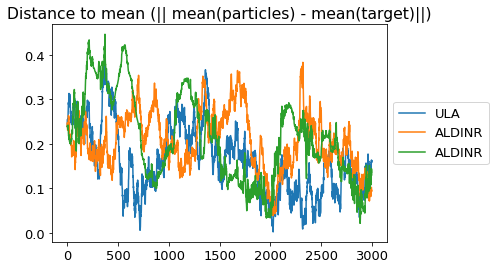

In [55]:
distances_to_mean_ULA = np.linalg.norm(means_ULA, axis=0)
plt.plot(distances_to_mean_ULA, label = 'ULA' )

distances_to_mean_ALDI = np.linalg.norm(means_ALDI, axis=0)
plt.plot(distances_to_mean_ALDI, label = 'ALDINR' )

distances_to_mean_ALDINR = np.linalg.norm(means_ALDINR, axis=0)
plt.plot(distances_to_mean_ALDINR, label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Distance to mean (|| mean(particles) - mean(target)||)')

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Text(0.5, 1.0, 'Average of the means along iterations')

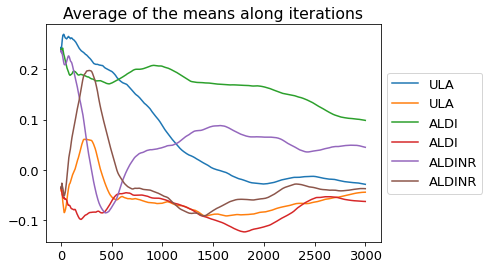

In [56]:
average_means_ULA = [np.mean(means_ULA[:, :i], axis = 1) for i in range(N_sim)]
average_means_ALDI =  [np.mean(means_ALDI[:, :i], axis = 1) for i in range(N_sim)]
average_means_ALDINR = [np.mean(means_ALDINR[:, :i], axis = 1) for i in range(N_sim)]
plt.plot(average_means_ULA, label = 'ULA' )
plt.plot(average_means_ALDI, label = 'ALDI' )
plt.plot(average_means_ALDINR, label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Average of the means along iterations')

Text(0.5, 1.0, 'Norm of C-K along iter')

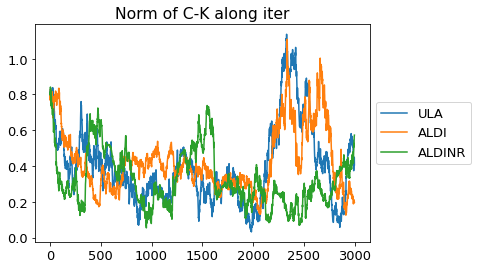

In [57]:
distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA[:, :, i]-K) for i in range(covariances_ULA.shape[2])])
plt.plot(distances_to_covariances_ULA, label ='ULA')

distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI[:, :, i]-K) for i in range(covariances_ALDI.shape[2])])
plt.plot(distances_to_covariances_ALDI, label ='ALDI')

distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR[:, :, i]-K) for i in range(covariances_ALDINR.shape[2])])
plt.plot(distances_to_covariances_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm of C-K along iter')

In [33]:
1/sqrt(J)

0.22360679774997896

Text(0.5, 1.0, 'Trace of C along ALDINR')

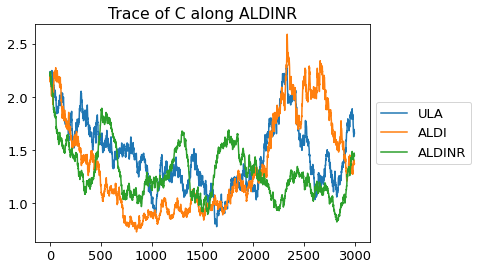

In [58]:
traces_of_C_ULA = np.asarray([np.trace(covariances_ULA[:, :, i]) for  i in range(covariances_ULA.shape[2])] )
traces_of_C_ALDI = np.asarray([np.trace(covariances_ALDI[:, :, i]) for  i in range(covariances_ALDI.shape[2])] )
traces_of_C_ALDINR = np.asarray([np.trace(covariances_ALDINR[:, :, i]) for  i in range(covariances_ALDINR.shape[2])] )

plt.plot(traces_of_C_ULA, label ='ULA')
plt.plot(traces_of_C_ALDI, label ='ALDI')
plt.plot(traces_of_C_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Trace of C along ALDINR')


### marginal of distribution of particles on last iterations

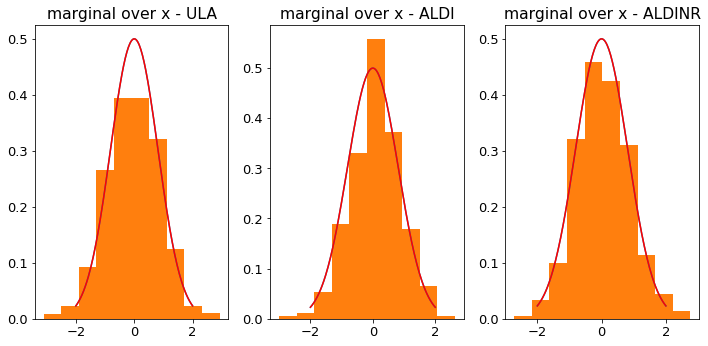

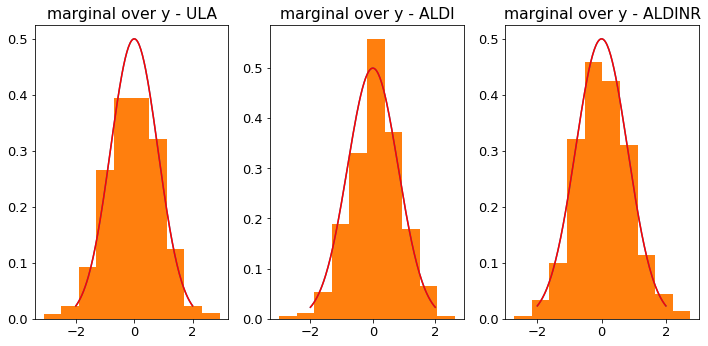

In [62]:
binsx = np.linspace(xmin,xmax,31)
binsy = np.linspace(ymin,ymax,31)

# marginal over x

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1,3,1)
plt.plot(u0s, marg_over_x)
plt.hist(us_list_ULA[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_x, color = 'red')
plt.title('marginal over x - ULA')

plt.subplot(1,3,2)
plt.plot(u0s, marg_over_x)
plt.hist(us_list_ALDI[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_x, color = 'red')
plt.title('marginal over x - ALDI')

plt.subplot(1,3,3)
plt.plot(u0s, marg_over_x)
plt.hist(us_list_ALDINR[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_x, color = 'red')
plt.title('marginal over x - ALDINR')
fig.tight_layout()

# marginal over y

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1,3,1)
plt.plot(u0s, marg_over_y)
plt.hist(us_list_ULA[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_y, color = 'red')
plt.title('marginal over y - ULA')

plt.subplot(1,3,2)
plt.plot(u0s, marg_over_y)
plt.hist(us_list_ALDI[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_y, color = 'red')
plt.title('marginal over y - ALDI')

plt.subplot(1,3,3)
plt.plot(u0s, marg_over_y)
plt.hist(us_list_ALDINR[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_y, color = 'red')
plt.title('marginal over y - ALDINR')
plt.tight_layout()